In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
from tqdm import tqdm
from glob import glob

# Read the file

In [2]:
json_list = sorted(glob("./jsons/*.json"))

In [3]:
len(json_list)

24

In [4]:
# jsons = fsspec.open_files("./test.json")
# with jsons[0] as afile:

ds_list = []
m_list = []
for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", fo=json.load(f), remote_protocol="s3", remote_options={"anon": True}))
#         ds = xr.open_dataset(m, engine="zarr")
#         ds_list.append(ds)

100%|██████████| 24/24 [00:08<00:00,  2.67it/s]


In [5]:
%%time
ds = xr.open_mfdataset(m_list, combine='nested', concat_dim='t',
                       engine='zarr', coords='minimal', 
                       data_vars='minimal', compat='override')

CPU times: user 6.28 s, sys: 349 ms, total: 6.63 s
Wall time: 2min 33s


## Now to do the same calculations/plotting as before

In [6]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [7]:
ds = calc_latlon(ds)

<ipython-input-6-faaad4e12a01>:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


## Unlike reading netCDF from s3fs directly, here doing `.where()` on lat/lon doesn't kill the kernel

### _This doesn't seem to be working as of June 7, the kernel dies on this step_

In [8]:
# %%time
# lat1, lat2 = (31, 53)
# lon1, lon2 = (-85, -56)

# subset = ds.where((ds.lat >= lat1) & (ds.lat <= lat2) & (ds.lon >= lon1) & (ds.lon <= lon2), drop=True)

## Get x/y from lat lon

In [9]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [10]:
%%time
lats = (31, 53)
lons = (-85, -56)

((x1,x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

CPU times: user 350 ms, sys: 60.4 ms, total: 410 ms
Wall time: 410 ms


In [11]:
# y slice must be y2, y1 since the `y` coordinate is decreasing
subset = ds.sel(x=slice(x1,x2), y=slice(y2, y1))
subset

<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 24, x: 1315, y: 776)
Coordinates:
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 dask.array<chunksize=(4,), meta=np.ndarray>
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    day_solar_zenith_angle                                  float32 ...
    night_solar_zenith_angle                                float32 ...
    quantitative_local_zenith_angle                         float32 ...
    retrieval_local_zenith_angle                            float32 ...
    retrieval_solar_zenith_angle                            float32 ...
  * t                                                       (t) datetime64[ns] ...
  * x                                                       (x) float32 -0.02...
    x_image                                                 float32 ...
  * y                                                       (y) float32 0.131...
    y_image                                                 float32 ...
    lat                                                     (y, x) float32 53...
    lon                                                     (y, x) float32 -9...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables:
    DQF                                                     (t, y, x) float32 dask.array<chunksize=(1, 89, 7), meta=np.ndarray>
    SST                                                     (t, y, x) float32 dask.array<chunksize=(1, 89, 7), meta=np.ndarray>
    algorithm_dynamic_input_data_container                  (t) float64 nan ....
    algorithm_product_version_container                     (t) float64 nan ....
    day_solar_zenith_angle_bounds                           (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    geospatial_lat_lon_extent                               (t) float64 nan ....
    goes_imager_projection                                  (t) float64 nan ....
    max_obs_modeled_diff_SST_night_only_emissive_band       (t) float64 5.511...
    max_retrieved_Reynolds_SST_diff                         (t) float64 14.68...
    maximum_sea_surface_temp                                (t) float64 317.7...
    mean_obs_modeled_diff_SST_night_only_emissive_band      (t) float64 -0.21...
    mean_retrieved_Reynolds_SST_diff                        (t) float64 0.082...
    mean_sea_surface_temp                                   (t) float64 286.4...
    min_obs_modeled_diff_SST_night_only_emissive_band       (t) float64 -5.61...
    min_retrieved_Reynolds_SST_diff                         (t) float64 -3.04...
    minimum_sea_surface_temp                                (t) float64 192.3...
    night_solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_height                                (t) float64 3.579...
    nominal_satellite_subpoint_lat                          (t) float64 0.0 ....
    nominal_satellite_subpoint_lon                          (t) float64 -75.2...
    number_of_day_SST_pixels                                (t) float64 7.664...
    number_of_night_SST_pixels                              (t) float64 2.145...
    number_of_twilight_SST_pixels        

### Single snapshot

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CPU times: user 1 s, sys: 89.2 ms, total: 1.09 s
Wall time: 8.08 s


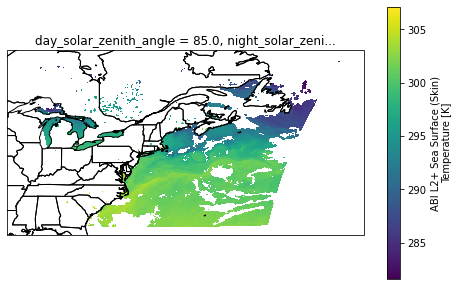

In [12]:
%%time

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
subset.SST.where(subset.DQF==0).isel(t=14).plot(x="lon", y="lat", ax=ax)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

### 1-Day mean

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CPU times: user 11.4 s, sys: 866 ms, total: 12.2 s
Wall time: 1min 30s


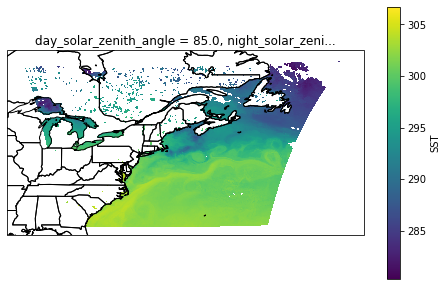

In [13]:
%%time

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
subset.SST.where(subset.DQF==0).mean('t', skipna=True).plot(x="lon", y="lat", ax=ax)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)